### SET UP

In [ ]:
# Cài Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Tải và giải nén Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz

# Cài findspark
!pip install -q findspark

# Thiết lập biến môi trường cho JAVA và SPARK
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

# Khởi tạo findspark
import findspark
findspark.init()

# Import SparkSession và khởi tạo
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("OnlineRestore") \
    .master("local[*]") \
    .getOrCreate()

# Kiểm tra phiên bản Spark
print("Spark version:", spark.version)


Spark version: 3.3.2


In [ ]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import TimestampType
from functools import reduce

In [ ]:
from google.colab import files
file= files.upload()

Saving OnlineRetail.csv to OnlineRetail (2).csv


### 2. Load data

In [ ]:
df = spark.read.csv("OnlineRetail.csv", header=True, inferSchema=True)
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



#### 3. Data Profiling, Anomaly Detection and Data Cleaning

##### 3.1 Check the number of colummns and rows

In [ ]:
# Check the number of columns and rows
print("Number of columns: ", len(df.columns))
print("Number of rows: ", df.count())

Number of columns:  8
Number of rows:  541909


##### 3.2 Abnormal 1: Check and correct Data Type

In [ ]:
# Check schema
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
# Convert datatype of InvoiceDate to timestamp
df_cleaned = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "M/d/yyyy H:mm"))

# Re-check schema
df_cleaned.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



### 3.3 Abnormal 2: Check and handle missing values

In [ ]:
# Check for missing values in original data
missing_values = df_cleaned.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
])
missing_values.show()


+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



- Description: 1,454 --> remove since it is hard to guess the product description
- CustomerID: 135,080 --> might keep them, change null value into Unknown

In [ ]:
# Delete the null values in Description
df_cleaned = df_cleaned.filter(df_cleaned.Description.isNotNull())

# Change the value in CustomerID into "Unknown" for null values
df_cleaned = df_cleaned.withColumn("CustomerID", when(df_cleaned.CustomerID.isNull(), "Unknown").otherwise(df_cleaned.CustomerID))

In [ ]:
# Re-check for missing values in the cleaned data
missing_values = df_cleaned.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
])
missing_values.show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



### 3.4 Abnormal 3: Check and handle duplicate rows

In [ ]:
# Check the number of duplicate rows
duplicate_count = df_cleaned.count() - df_cleaned.dropDuplicates().count()
print("Number of duplicate rows: ", duplicate_count)

Number of duplicate rows:  5268


In [ ]:
# Drop duplicate rows
df_cleaned = df_cleaned.dropDuplicates()

In [ ]:
# Re-check the number of duplicate rows
duplicate_count = df_cleaned.count() - df_cleaned.dropDuplicates().count()
print("Number of duplicate rows: ", duplicate_count)

Number of duplicate rows:  0


### 3.5 Abnormal 4: Handle negative Quantity and UnitPrice

### Check the number of cancelled order: The InvoiceNo starts with C (has negative Quantity)

In [ ]:
cancel = df_cleaned.filter(col("InvoiceNo").startswith("C"))
print("Number of canceled orders: ", cancel.count())
cancel.show(5)

Number of canceled orders:  9251
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  C536606|    20914|SET/5 RED RETROSP...|      -2|2010-12-02 09:10:00|     2.95|     14092|United Kingdom|
|  C537998|    22727|ALARM CLOCK BAKEL...|      -4|2010-12-09 11:42:00|     3.75|     17411|United Kingdom|
|  C538723|    22333|RETROSPOT PARTY B...|      -7|2010-12-14 11:12:00|     1.65|     12434|     Australia|
|  C538763|    22107|  PIZZA PLATE IN BOX|      -8|2010-12-14 11:33:00|     3.75|     17722|United Kingdom|
|  C539278|    22617|BAKING SET SPACEB...|      -6|2010-12-16 15:39:00|     4.95|     18269|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+-----------

### Check for invalid values in Quantity and UnitPrice:

- Quantity < 0
- UnitPrice < 0

In [ ]:
# Quantity has negative value
negative_Quantity = df_cleaned.filter(col("Quantity") < 0).count()
print("Number of negative Quantity: ", negative_Quantity)
df_cleaned.filter(col("Quantity") < 0).select("InvoiceNo", "Quantity").show(5)

Number of negative Quantity:  9725
+---------+--------+
|InvoiceNo|Quantity|
+---------+--------+
|  C536606|      -2|
|  C537998|      -4|
|  C538723|      -7|
|  C538763|      -8|
|  C539278|      -6|
+---------+--------+
only showing top 5 rows



In [ ]:
# UnitPrice has negative value
negative_UnitPrice = df_cleaned.filter(col("UnitPrice") < 0).count()
print("Number of negative UnitPrice: ", negative_UnitPrice)
df_cleaned.filter(col("UnitPrice") < 0).select("InvoiceNo", "UnitPrice").show(5)

Number of negative UnitPrice:  2
+---------+---------+
|InvoiceNo|UnitPrice|
+---------+---------+
|  A563187|-11062.06|
|  A563186|-11062.06|
+---------+---------+



- We can see that cancelled orders also have the negative Quantity.
- The dataset contains 9,251 cancelled orders, while 9,725 orders have a negative quantity.
- Therefore, in the Data Cleaning section, when we remove orders with negative quantities, we also remove the cancelled orders at the same time.

### Remove abnormal Quantity and UnitPrice

In [ ]:
# Filter out negative Quantity and UnitPrice
df_cleaned = df_cleaned.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

# Check negative Quantity and UnitPrice again
print("Negative Quantity count:", df_cleaned.filter(col("Quantity") < 0).count())
print("Negative UnitPrice count:", df_cleaned.filter(col("UnitPrice") < 0).count())

# Check number of cancelled orders again
cancel = df_cleaned.filter(col("InvoiceNo").startswith("C"))
print("Number of cancelled orders: ", cancel.count())

Negative Quantity count: 0
Negative UnitPrice count: 0
Number of cancelled orders:  0


### 3.6 Abnormal 5: Identify abnormal StockCode-Description pairs that are not actual products
- Check abnormal StockCode

In [ ]:
excluded_stockcodes = ["POST", "DOT", "M", "C2", "BANK CHARGES","S", "B", "AMAZONFEE",
                       "gift_0001_10", "gift_0001_20","gift_0001_30","gift_0001_40","gift_0001_50"]

# Identify rows with exclued StockCode
df_excluded = df_cleaned.filter(col("StockCode").isin(excluded_stockcodes))

# Show distinct excluded StockCode - Description pairs
df_excluded.select("StockCode", "Description").distinct().show(truncate=False)

+------------+----------------------------------+
|StockCode   |Description                       |
+------------+----------------------------------+
|POST        |POSTAGE                           |
|DOT         |DOTCOM POSTAGE                    |
|gift_0001_40|Dotcomgiftshop Gift Voucher �40.00|
|C2          |CARRIAGE                          |
|gift_0001_30|Dotcomgiftshop Gift Voucher �30.00|
|BANK CHARGES|Bank Charges                      |
|M           |Manual                            |
|AMAZONFEE   |AMAZON FEE                        |
|gift_0001_50|Dotcomgiftshop Gift Voucher �50.00|
|gift_0001_20|Dotcomgiftshop Gift Voucher �20.00|
|S           |SAMPLES                           |
|gift_0001_10|Dotcomgiftshop Gift Voucher �10.00|
|B           |Adjust bad debt                   |
+------------+----------------------------------+



### Handle abnormal StockCode and Description pairs that are not actual products

In [ ]:
df_cleaned = df_cleaned.filter(~col("StockCode").isin(excluded_stockcodes))

In [ ]:
# Re-check the abnormal stock code
df_excluded = df_cleaned.filter(col("StockCode").isin(excluded_stockcodes))
df_excluded.select("StockCode", "Description").distinct().show(truncate=False)

+---------+-----------+
|StockCode|Description|
+---------+-----------+
+---------+-----------+



### 4. Data cleaning results

In [ ]:
# The number of rows before cleaning
rows_before_cleaning = df.count()
print(f"Number of rows before cleaning: {rows_before_cleaning}")

Number of rows before cleaning: 541909


In [ ]:
# Check the number of rows after cleaning
rows_after_cleaning = df_cleaned.count()
print(f"Number of rows after cleaning: {rows_after_cleaning}")

Number of rows after cleaning: 522541


### 5. Feature Engineering

In [ ]:
# Convert InvoiceDate data type to DateType
df_fe = df_cleaned.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "M/d/yyyy H:mm"))
df_fe.printSchema()
df_fe.show(5)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536415|    22951|60 CAKE CASES DOL...|       2| 2010-12-01|     0.55|     12838|United Kingdom|
|   536488|    22909|SET OF 20 VINTAGE...|       1| 2010-12-01|     0.85|     17897|United Kingdom|
|   536592|    22665|RECIPE BOX BLUE S...|       1| 2010-12-01|     5.91|   Unknown|United Kingdom|
|   536600|   84029G|KNITTED UNION FLA...|       6| 2010-12-02|  

In [ ]:
# Get the max date of the dataset
max_date = df_fe.agg(max("InvoiceDate")).collect()[0][0]
max_date

datetime.date(2011, 12, 9)

In [ ]:
# Calculate recency
recency_df = df_fe.groupBy("CustomerID").agg(
    datediff(lit(max_date), max("InvoiceDate")).alias("Recency")
)
recency_df.show(5)


+----------+-------+
|CustomerID|Recency|
+----------+-------+
|     16250|    261|
|     15574|    177|
|     15555|     12|
|     15271|      7|
|     17714|    320|
+----------+-------+
only showing top 5 rows



In [ ]:
# Calculate frequency (number of transactions per customer)
frequency_df = df_fe.groupBy("CustomerID").agg(
    countDistinct("InvoiceNo").alias("Frequency")
)
frequency_df.show(5)

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|     15555|       16|
|     15574|        4|
|     14157|        2|
|     17686|        7|
|     13610|        7|
+----------+---------+
only showing top 5 rows



In [ ]:
# Calculate Monetary (Total money spent by customer)
monetary_df = df_fe.withColumn("TotalPrice", col("Quantity") * col("UnitPrice")) \
    .groupBy("CustomerID") \
    .agg(round(sum("TotalPrice"), 3).alias("Monetary"))
monetary_df.show(5)

+----------+--------+
|CustomerID|Monetary|
+----------+--------+
|     13610| 1082.33|
|     15555| 4791.87|
|     15271| 2493.34|
|     15574|  675.64|
|     13282| 1132.14|
+----------+--------+
only showing top 5 rows



In [ ]:
# Join all RFM features
dfs = [recency_df, frequency_df, monetary_df]
rfm_df = reduce(lambda df1, df2: df1.join(df2, "CustomerID"), dfs)
rfm_df.show(5)


+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15555|     12|       16| 4791.87|
|     15574|    177|        4|  675.64|
|     14157|     19|        2|  424.89|
|     17686|      7|        7| 5739.46|
|     13610|     12|        7| 1082.33|
+----------+-------+---------+--------+
only showing top 5 rows



In [ ]:
# Calculate the average of Recency, Frequency, and Monetary
rfm_df.select(
    mean("Recency").alias("Mean_Recency"),
    mean("Frequency").alias("Mean_Frequency"),
    mean("Monetary").alias("Mean_Monetary")
).show()

+-----------------+-----------------+-----------------+
|     Mean_Recency|   Mean_Frequency|    Mean_Monetary|
+-----------------+-----------------+-----------------+
|92.20530565167243|4.561245674740484|2363.834342099192|
+-----------------+-----------------+-----------------+



### Final Dataframe

- If you want to work with timestamp (yyyy-M-d H:mm:ss) data, please use the code: [df_cleaned.join()]
- If you want to work with date (only yyyy=M-d), please change the below code:[df_cleaned.join()] --> [df_fe.join()]

In [ ]:
# Join churn label into transaction-level cleaned data
final_df = rfm_df.join(df_cleaned, on="CustomerID", how="left")
final_df.show()

+----------+-------+---------+--------+---------+---------+--------------------+--------+-------------------+---------+-------+
|CustomerID|Recency|Frequency|Monetary|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|Country|
+----------+-------+---------+--------+---------+---------+--------------------+--------+-------------------+---------+-------+
|     12394|     63|        2| 1080.48|   552188|    22557|PLASTERS IN TIN V...|      12|2011-05-06 14:01:00|     1.65|Belgium|
|     12394|     63|        2| 1080.48|   552188|    22551|PLASTERS IN TIN S...|      12|2011-05-06 14:01:00|     1.65|Belgium|
|     12394|     63|        2| 1080.48|   552188|    21244|BLUE POLKADOT PLATE |       8|2011-05-06 14:01:00|     1.69|Belgium|
|     12394|     63|        2| 1080.48|   552188|    23256|CHILDRENS CUTLERY...|       8|2011-05-06 14:01:00|     4.15|Belgium|
|     12394|     63|        2| 1080.48|   552188|    21245|GREEN POLKADOT PL...|       8|2011-05-06 14:0

- For further steps after my parts, I got a few instruction for each role of the type of dataframe

- df: original raw dataframe
- df_cleaned: dataframe after data cleaning in part 3
- df_fe : dataframe where the InvoiceDate converted into Date formula.
- rfm_df : The RFM dataframe with columns [CustomerID, Recency, Frequency, Monetary, Churn]
- final_df (optional) : use this if you prefer working directly with the cleaned transactional data (df_cleaned) rather than the aggregated RFM data.



---



---



---



---



---



In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans


In [ ]:
rfm = final_df.select("CustomerID","Recency", "Frequency", "Monetary")
rfm.show()

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
|     15555|     12|       16| 4791.87|
+----------+-------+---------+--------+
only showing top 20 rows



In [ ]:
print(rfm.count())

522541


# Normalize RFM

In [ ]:
# Assemble
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary"], outputCol="features")
final_vector = assembler.transform(rfm)

# Scale (fit only on train)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(final_vector)
final_scaled = scaler_model.transform(final_vector)


#Clustering
K-Means

### Compare KMeans with Different k Values

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

for k in range(2, 10):
    kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=k, seed=1)
    model = kmeans.fit(final_scaled)
    transformed = model.transform(final_scaled)

    evaluator = ClusteringEvaluator(featuresCol="scaled_features",
                                    predictionCol="cluster", metricName="silhouette")
    silhouette = evaluator.evaluate(transformed)
    print(f"With k= {k} → Silhouette Score = {silhouette}")


With k= 2 → Silhouette Score = 0.8775858239212301
With k= 3 → Silhouette Score = 0.9417731726244167
With k= 4 → Silhouette Score = 0.8957739774828374
With k= 5 → Silhouette Score = 0.876522439834906
With k= 6 → Silhouette Score = 0.8358600021989957
With k= 7 → Silhouette Score = 0.7935364669055627
With k= 8 → Silhouette Score = 0.7884081866303813
With k= 9 → Silhouette Score = 0.7883784193227261


The highest Silhouette Score is  0.9417731726244167. So, the best k values is: k = 3

# Evaluate Clustering


In [ ]:
k_best = 3
kmeans = KMeans(featuresCol="scaled_features",
                predictionCol="cluster",k= k_best, seed =1)
km_model =kmeans.fit(final_scaled)
final_pred = km_model.transform(final_scaled)
final_pred.show()

+----------+-------+---------+--------+-------------------+--------------------+-------+
|CustomerID|Recency|Frequency|Monetary|           features|     scaled_features|cluster|
+----------+-------+---------+--------+-------------------+--------------------+-------+
|     15555|     12|       16| 4791.87|[12.0,16.0,4791.87]|[0.20164798681824...|      0|
|     15555|     12|       16| 4791.87|[12.0,16.0,4791.87]|[0.20164798681824...|      0|
|     15555|     12|       16| 4791.87|[12.0,16.0,4791.87]|[0.20164798681824...|      0|
|     15555|     12|       16| 4791.87|[12.0,16.0,4791.87]|[0.20164798681824...|      0|
|     15555|     12|       16| 4791.87|[12.0,16.0,4791.87]|[0.20164798681824...|      0|
|     15555|     12|       16| 4791.87|[12.0,16.0,4791.87]|[0.20164798681824...|      0|
|     15555|     12|       16| 4791.87|[12.0,16.0,4791.87]|[0.20164798681824...|      0|
|     15555|     12|       16| 4791.87|[12.0,16.0,4791.87]|[0.20164798681824...|      0|
|     15555|     12| 

In [ ]:
cluster_counts = final_pred.groupBy("cluster").count().orderBy("cluster")
cluster_counts.show()


+-------+------+
|cluster| count|
+-------+------+
|      0|353667|
|      1|131388|
|      2| 37486|
+-------+------+



In [ ]:
cluster_counts_pd = cluster_counts.toPandas()


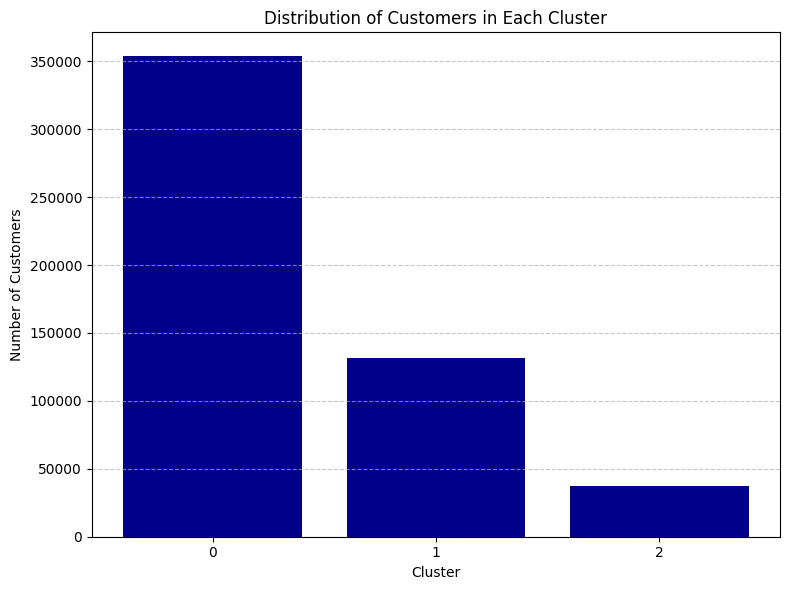

In [ ]:
import matplotlib.pyplot as plt

# Bar chart of cluster distribution
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts_pd['cluster'], cluster_counts_pd['count'], color='darkblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customers in Each Cluster')
plt.xticks(cluster_counts_pd['cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Statistics for each cluster

In [ ]:
from pyspark.sql import functions as F

features =["Recency", "Frequency", "Monetary"]
agg_exprs = []
for col in features:
    agg_exprs.extend([
        F.min(col).alias(f"{col}_min"),
        F.avg(col).alias(f"{col}_mean"),
        F.expr(f'percentile({col}, 0.5)').alias(f"{col}_median"),
        F.max(col).alias(f"{col}_max")
    ])

summary_df = final_pred.groupBy("cluster").agg(*agg_exprs)
summary_df.orderBy("cluster").show(truncate=False)

+-------+-----------+------------------+--------------+-----------+-------------+------------------+----------------+-------------+------------+------------------+---------------+------------+
|cluster|Recency_min|Recency_mean      |Recency_median|Recency_max|Frequency_min|Frequency_mean    |Frequency_median|Frequency_max|Monetary_min|Monetary_mean     |Monetary_median|Monetary_max|
+-------+-----------+------------------+--------------+-----------+-------------+------------------+----------------+-------------+------------+------------------+---------------+------------+
|0      |0          |22.263114737874893|12.0          |117        |1            |20.297002547594207|8.0             |206          |5.9         |12276.931437796062|2993.1         |279138.02   |
|1      |0          |0.0               |0.0           |0          |1371         |1371.0            |1371.0          |1371         |1509994.23  |1509994.2300024081|1509994.23     |1509994.23  |
|2      |119        |215.3068879048

In [ ]:
centers = km_model.clusterCenters()
print("Cluster Centers:")
for i, c in enumerate(centers):
    print(f"Cluster {i}: {c}")


Cluster Centers:
Cluster 0: [0.37410936 0.03454308 0.01886497]
Cluster 1: [0.         2.33327836 2.32028621]
Cluster 2: [3.61801671e+00 4.64332930e-03 1.56486341e-03]


In [ ]:
import pandas as pd

stats = summary_df.collect()
centers = km_model.clusterCenters()

all_cluster_tables = []

for row in stats:
    cluster_id = row['cluster']

    cluster_data = {
        "Metric": ["Recency", "Frequency", "Monetary"],
        "Min": [row['Recency_min'], row['Frequency_min'], row['Monetary_min']],
        "Mean": [row['Recency_mean'], row['Frequency_mean'], row['Monetary_mean']],
        "Median": [row['Recency_median'], row['Frequency_median'], row['Monetary_median']],
        "Max": [row['Recency_max'], row['Frequency_max'], row['Monetary_max']],

        "Cluster Center": centers[cluster_id]  # array [r, f, m]
    }

    cluster_data["Cluster Center"] = list(centers[cluster_id])

    df = pd.DataFrame(cluster_data)
    df.insert(0, "Cluster", cluster_id)
    all_cluster_tables.append(df)


In [ ]:
for cluster_df in all_cluster_tables:
    cluster_id = cluster_df['Cluster'].iloc[0]
    print(f"\n====== Cluster {cluster_id} ===========================================================")
    print(cluster_df.to_string(index=False))



====== Cluster 1 ===========================================================
 Cluster    Metric        Min         Mean     Median        Max  Cluster Center
       1   Recency       0.00 0.000000e+00       0.00       0.00        0.000000
       1 Frequency    1371.00 1.371000e+03    1371.00    1371.00        2.333278
       1  Monetary 1509994.23 1.509994e+06 1509994.23 1509994.23        2.320286

====== Cluster 2 ===========================================================
 Cluster    Metric    Min        Mean  Median     Max  Cluster Center
       2   Recency 119.00  215.306888  196.00   373.0        3.618017
       2 Frequency   1.00    2.728352    2.00    34.0        0.004643
       2  Monetary   3.75 1018.380711  610.01 77183.6        0.001565

====== Cluster 0 ===========================================================
 Cluster    Metric  Min         Mean  Median       Max  Cluster Center
       0   Recency  0.0    22.263115    12.0    117.00        0.374109
       0 Frequency  

**Cluster 0:**

| Metric    | Min | Mean      | Median   | Max        | Center (Scaled) |
| --------- | --- | --------- | -------- | ---------- | --------------- |
| Recency   | 0   | 22.33     | 12.00    | 119.00     | 0.38            |
| Frequency | 1   | 20.31     | 8.00     | 206.00     | 0.03            |
| Monetary  | 30  | 12,288.85 | 2,984.49 | 279,138.02 | 0.02            |

 - **Low Recency**→ These customers have purchased very recently, with a median of **12 day**s ago, and average of around **23 days**  
 - **Medium Frequency**→ Average around **20 purchases**, and some up to **206**.
 - **Monetary →** their spending is moderate, with an average monetary value of about **12k** and a median of around **3k** and up to **279k**

 → Cluster 0 : *Active Medium-Value Customers* - These are your regular customers with decent purchase frequency and moderate spending.


**Cluster 1:**

| Metric    | Min    | Mean    | Median  | Max     | Center (Scaled) |
| --------- | ------ | ------- | ------- | ------- | --------------- |
| Recency   | 0.00   | 0.00    | 0.00    | 0.00    | 0.00            |
| Frequency | 1371.0 | 1371.00 | 1371.00 | 1371.00 | 2.33            |
| Monetary  | 1.5M   | 1.5M    | 1.5M    | 1.5M    | 2.32            |

- **Recency = 0** → Purchased today (most recent customer).

- **Extremely High Frequency** → 1371 purchases.

- **Extremely High Monetary** → Spent over 1.5 million.

→ Cluster 1: *Ultra VIP Customer* - This is a rare but critical customer. These are best customers loyal, frequent, and very high spenders


**Cluster 2:**

| Metric    | Min  | Mean     | Median | Max      | Center (Scaled) |
| --------- | ---- | -------- | ------ | -------- | --------------- |
| Recency   | 120  | 215.53   | 196.0  | 373.0    | 3.63            |
| Frequency | 1    | 2.74     | 2.0    | 34.0     | 0.00            |
| Monetary  | 3.75 | 1,032.45 | 609.4  | 44,534.3 | 0.00            |

- **High Recency** → These customers haven't purchased for a long time  with recency values from **120** up to **373** days, and an average of **215** days. This suggests that they are likely churned or inactive.
- **Low Frequency**→ They purchase very rarely, on average just **2-3** purchase (median 2 and max 34), which is extremely low.
- **Low Monetary** → Their monetary values are low on average, around **1k**, but with a wide spread (**median 609** and **max over 44k**)

→ Cluster 2: *Churned Low-Value Customers* - This cluster represents churned or near-churn customers who have low engagement and low spending.



---


**SUMMARY:**

| Cluster | Label                      | Key Traits                                               |
| ------- | -------------------------- | -------------------------------------------------------- |
| 0       | Active Medium-Value Customers   | Regular, recent, moderate to high spending   |
| 1       | Ultra VIP Customer        | Bought recently, frequently, and very high value    |
| 2       | Churned Low-Value Customers    | 	Long inactive, rare purchases, low value          |


---



# pie chart customer segmentation and associated sales by cluster.


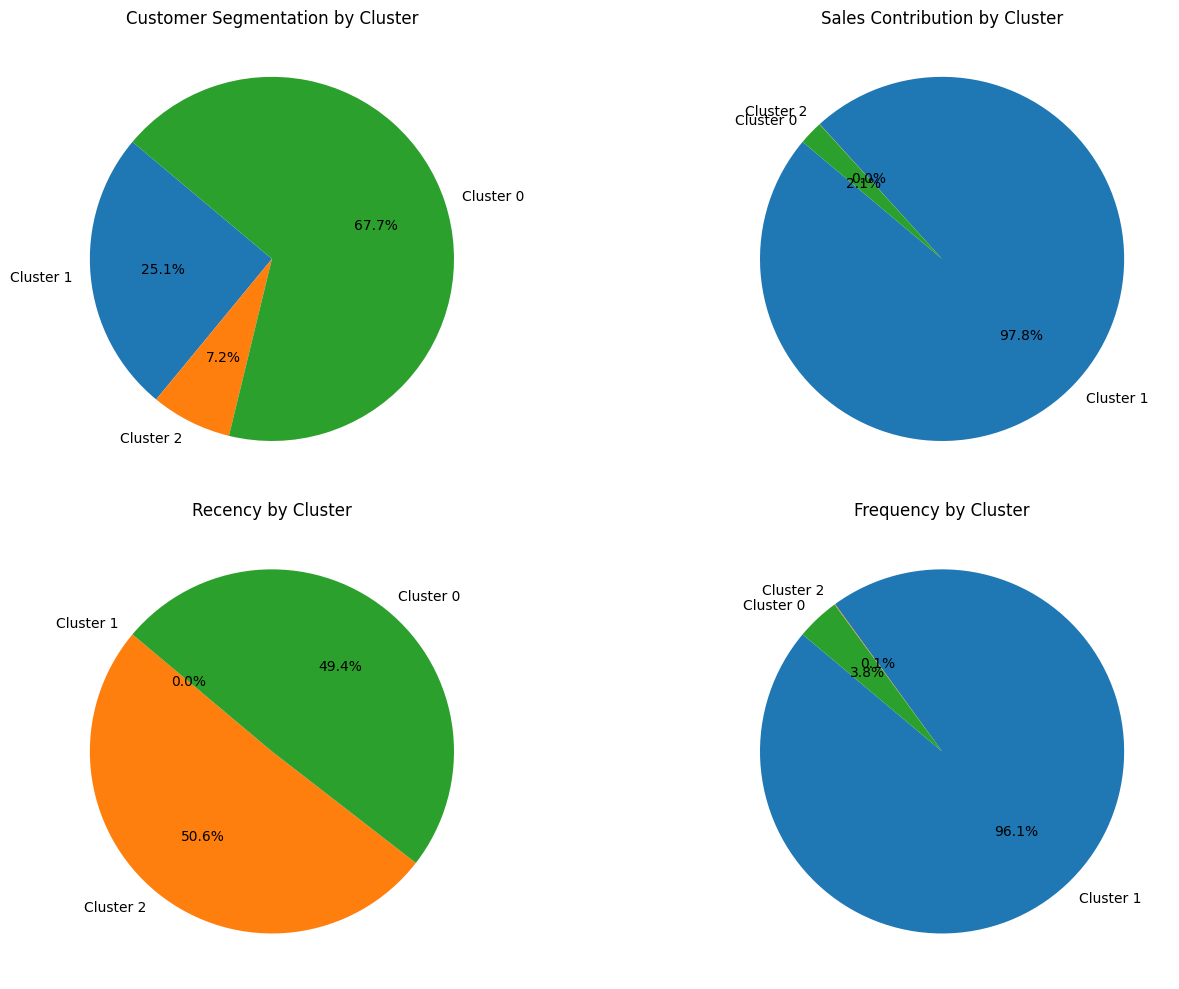

In [ ]:
import matplotlib.pyplot as plt


# Group by cluster prediction
summary_df = final_pred.groupBy("cluster").agg(
    count("*").alias("CustomerCount"),
    F.sum("Recency").alias("days_since_last_purchase"),
    F.sum("Frequency").alias("total_purchases"),
    F.sum("Monetary").alias("total_sales")

)

# Convert to Pandas for plotting
summary_pd = summary_df.toPandas()

# Extract labels and values
labels = [f"Cluster {i}" for i in summary_pd["cluster"]]
customer_counts = summary_pd["CustomerCount"]
Recency = summary_pd["days_since_last_purchase"]
Frequency = summary_pd["total_purchases"]
sales = summary_pd["total_sales"]

# Create 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2x2 array to a 1D array of 4 axes

# Pie chart 1: Customer Segmentation
axs[0].pie(customer_counts, labels=labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title("Customer Segmentation by Cluster")

# Pie chart 2: Sales Contribution
axs[1].pie(sales, labels=labels, autopct='%1.1f%%', startangle=140)
axs[1].set_title("Sales Contribution by Cluster")

# Pie chart 3: Recency by Cluster
axs[2].pie(Recency, labels=labels, autopct='%1.1f%%', startangle=140)
axs[2].set_title("Recency by Cluster")

# Pie chart 4: Frequency by Cluster
axs[3].pie(Frequency, labels=labels, autopct='%1.1f%%', startangle=140)
axs[3].set_title("Frequency by Cluster")

# Layout adjustment
plt.tight_layout()
plt.show()


# Model Saving

In [ ]:
import os

folder_path = "./models"

In [ ]:
model_path = "./models/kmeans_model"
km_model.write().overwrite().save(model_path)



---



---



---



---



---



---

